In [73]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [74]:
# hyperparams
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [75]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

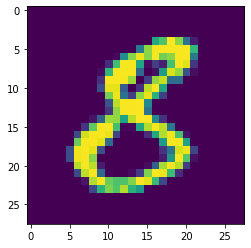

In [76]:
import matplotlib.pyplot as plt

plt.imshow(dataset_test.data[1234].detach().numpy())
plt.show()

In [85]:
# VAE

# 28x28 -> 7x7
class Encoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, latent_ch=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=2, 
                           padding=2) # 28x28 -> 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2) # 7x7
    self.conv_mu = nn.Conv2d(hidden_ch, latent_ch, kernel_size=3, padding=1)
    self.conv_sigma = nn.Conv2d(hidden_ch, latent_ch, kernel_size=3, padding=1)

    self.do1 = nn.Dropout(0.1)
    self.do2 = nn.Dropout(0.1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(self.do1(self.activ(x)))
    x = self.pool(self.do2(self.activ(x)))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, output_ch, hidden_ch, latent_ch=1):
    super().__init__()
    self.conv1 = nn.Conv2d(latent_ch, hidden_ch, kernel_size=3, padding=1)
    self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=2)
    self.convtr = nn.ConvTranspose2d(hidden_ch, output_ch, kernel_size=6, 
                                    stride=2, padding=2)

    self.do1 = nn.Dropout(0.1)
    self.do2 = nn.Dropout(0.1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(self.upsample(self.do1(self.activ(x))))
    x = self.conv3(self.upsample(self.do1(self.activ(x))))
    x = self.convtr(self.do2(self.activ(x)))
    return x

def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))

class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, latent_ch=10):
    super().__init__()
    self.encoder = Encoder(input_ch, hidden_ch, latent_ch)
    self.decoder = Decoder(input_ch, hidden_ch, latent_ch)

  def forward(self, x):
    mu, sigma = self.encoder(x)
    x = sampling(mu, sigma)
    x = self.decoder(x)
    return x, mu, sigma

epoch: 0, step: 0, tot_loss: 0.552682638168335, loss: 1.0423763990402222, kl_loss: 0.020996302366256714
epoch: 0, step: 200, tot_loss: 0.1523330807685852, loss: 0.2835913598537445, kl_loss: 0.007024936843663454
epoch: 0, step: 400, tot_loss: 0.13977530598640442, loss: 0.24992358684539795, kl_loss: 0.009875678457319736


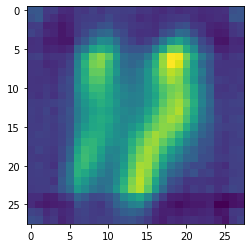

epoch: 1, step: 0, tot_loss: 0.14286984503269196, loss: 0.2506430149078369, kl_loss: 0.011698893271386623
epoch: 1, step: 200, tot_loss: 0.13798238337039948, loss: 0.23403385281562805, kl_loss: 0.013976968824863434
epoch: 1, step: 400, tot_loss: 0.1315872222185135, loss: 0.20450370013713837, kl_loss: 0.019556911662220955


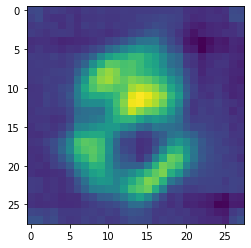

epoch: 2, step: 0, tot_loss: 0.12471495568752289, loss: 0.18924474716186523, kl_loss: 0.020061718299984932
epoch: 2, step: 200, tot_loss: 0.12195020169019699, loss: 0.18644759058952332, kl_loss: 0.01915093883872032
epoch: 2, step: 400, tot_loss: 0.12171764671802521, loss: 0.18122434616088867, kl_loss: 0.02073698118329048


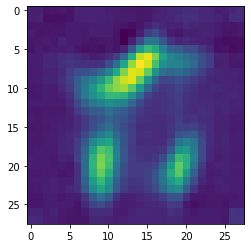

epoch: 3, step: 0, tot_loss: 0.11819745600223541, loss: 0.16974852979183197, kl_loss: 0.02221546322107315
epoch: 3, step: 200, tot_loss: 0.11832588911056519, loss: 0.16750900447368622, kl_loss: 0.023047594353556633
epoch: 3, step: 400, tot_loss: 0.11471134424209595, loss: 0.16452771425247192, kl_loss: 0.02163165621459484


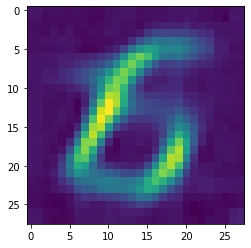

epoch: 4, step: 0, tot_loss: 0.11906898021697998, loss: 0.17169298231601715, kl_loss: 0.02214832603931427
epoch: 4, step: 200, tot_loss: 0.11460752040147781, loss: 0.15702247619628906, kl_loss: 0.024064186960458755
epoch: 4, step: 400, tot_loss: 0.11970435082912445, loss: 0.17537882924079895, kl_loss: 0.0213432926684618


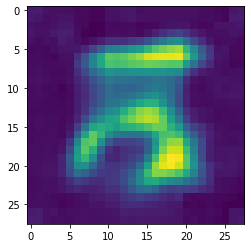

epoch: 5, step: 0, tot_loss: 0.11374751478433609, loss: 0.1594516932964325, kl_loss: 0.022681113332509995
epoch: 5, step: 200, tot_loss: 0.11577829718589783, loss: 0.1637481302022934, kl_loss: 0.022602824494242668
epoch: 5, step: 400, tot_loss: 0.11207213997840881, loss: 0.15598125755786896, kl_loss: 0.022721005603671074


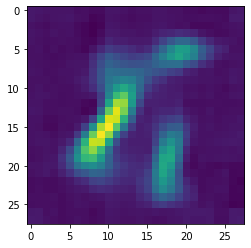

epoch: 6, step: 0, tot_loss: 0.11264856159687042, loss: 0.15362249314785004, kl_loss: 0.023891545832157135
epoch: 6, step: 200, tot_loss: 0.11370129883289337, loss: 0.15852925181388855, kl_loss: 0.022957781329751015
epoch: 6, step: 400, tot_loss: 0.10791109502315521, loss: 0.14437569677829742, kl_loss: 0.023815497756004333


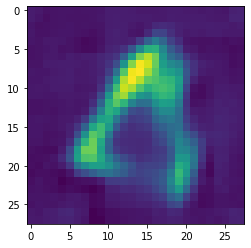

epoch: 7, step: 0, tot_loss: 0.11268021166324615, loss: 0.15842652320861816, kl_loss: 0.022311298176646233
epoch: 7, step: 200, tot_loss: 0.11279287934303284, loss: 0.156703382730484, kl_loss: 0.022960791364312172
epoch: 7, step: 400, tot_loss: 0.11243819445371628, loss: 0.15343576669692993, kl_loss: 0.02381354197859764


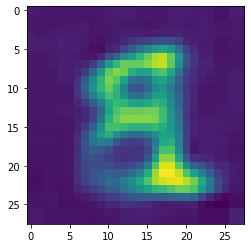

epoch: 8, step: 0, tot_loss: 0.11712970584630966, loss: 0.16170090436935425, kl_loss: 0.024186167865991592
epoch: 8, step: 200, tot_loss: 0.1101670190691948, loss: 0.15054595470428467, kl_loss: 0.023262694478034973
epoch: 8, step: 400, tot_loss: 0.1127869114279747, loss: 0.1598387062549591, kl_loss: 0.021911704912781715


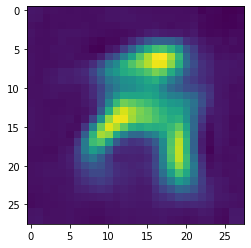

epoch: 9, step: 0, tot_loss: 0.11155915260314941, loss: 0.1493440717458725, kl_loss: 0.024591410532593727
epoch: 9, step: 200, tot_loss: 0.11185231804847717, loss: 0.15325137972831726, kl_loss: 0.02348441816866398
epoch: 9, step: 400, tot_loss: 0.11895625293254852, loss: 0.1658911406993866, kl_loss: 0.024007121101021767


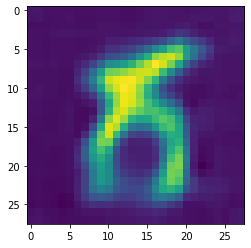

In [89]:
#denoise
input_ch = 1
hidden_ch = 32
model = VariationalAutoEncoder(input_ch, hidden_ch).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()
noise_factor = 0.5

def kl_loss_func(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

for epoch in range(10):
    
    for i, batch in enumerate(trainloader):
        optim.zero_grad()
        data = batch[0].to(device)
        predict, mu, sigma = model(data)
        kl_loss = kl_loss_func(mu, sigma)
        loss = loss_func(predict, data)
        tot_loss = 0.5 *loss + 1.5 * kl_loss
        tot_loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, tot_loss: {tot_loss.item()}, '
            f'loss: {loss.item()}, kl_loss: {kl_loss.item()}')
    model.eval()
    with torch.no_grad():
        item = dataset_test[1234][0].view(1, 1, 28, 28).to(device)
        plt.imshow(model(item)[0].view(28, 28).cpu().detach().numpy())
        plt.show()
    model.train()

    torch.save(model.state_dict(), f'./conv_chkpt_conv_{epoch}.pth')

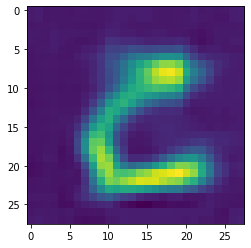

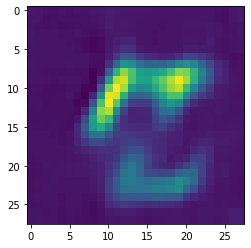

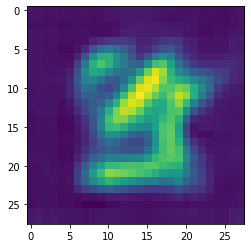

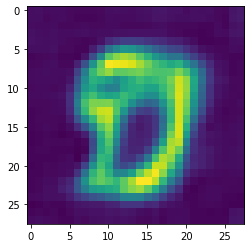

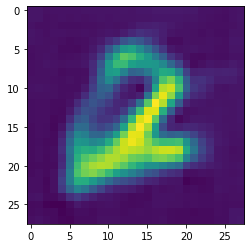

In [90]:
model.eval()
with torch.no_grad():
    for _ in range(5):
        hidden = torch.normal(torch.zeros((1,10,7,7)), torch.ones((1,10,7,7))).to(device)

        plt.imshow(model.decoder(hidden).view(28, 28).cpu().detach().numpy())
        plt.show()